In [ ]:
# Installation
!pip install xgboost scikit-learn optuna joblib matplotlib seaborn


[I 2025-06-21 16:48:54,868] A new study created in memory with name: no-name-7a05c84b-ec59-4c5e-8785-67424cd7378b
[I 2025-06-21 16:49:05,899] Trial 0 finished with value: 0.7427776627529312 and parameters: {'n_estimators': 193, 'max_depth': 6, 'learning_rate': 0.1354511207017002, 'subsample': 0.5906717591441166, 'colsample_bytree': 0.7048369770032819, 'gamma': 4.0966169443393765, 'min_child_weight': 1}. Best is trial 0 with value: 0.7427776627529312.
[I 2025-06-21 16:49:23,451] Trial 1 finished with value: 0.7345815300807942 and parameters: {'n_estimators': 257, 'max_depth': 9, 'learning_rate': 0.07989594566209134, 'subsample': 0.6910011281680744, 'colsample_bytree': 0.8917770399131454, 'gamma': 0.6018839822873834, 'min_child_weight': 10}. Best is trial 0 with value: 0.7427776627529312.
[I 2025-06-21 16:49:28,081] Trial 2 finished with value: 0.7413029495001242 and parameters: {'n_estimators': 114, 'max_depth': 8, 'learning_rate': 0.2375290378793371, 'subsample': 0.9350561453213995, 'c

AUC = 0.851
F1  = 0.743
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      6252
           1       0.74      0.74      0.74      5668

    accuracy                           0.76     11920
   macro avg       0.76      0.76      0.76     11920
weighted avg       0.76      0.76      0.76     11920


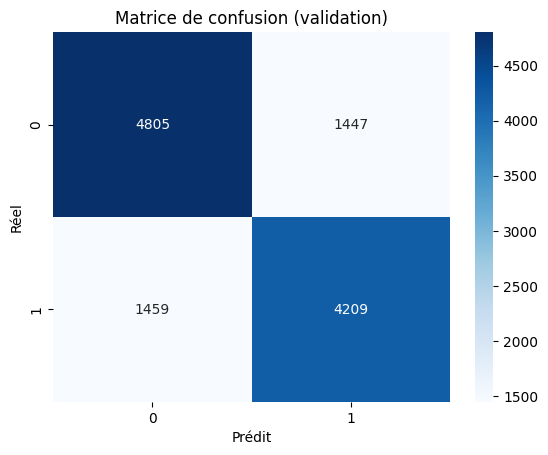

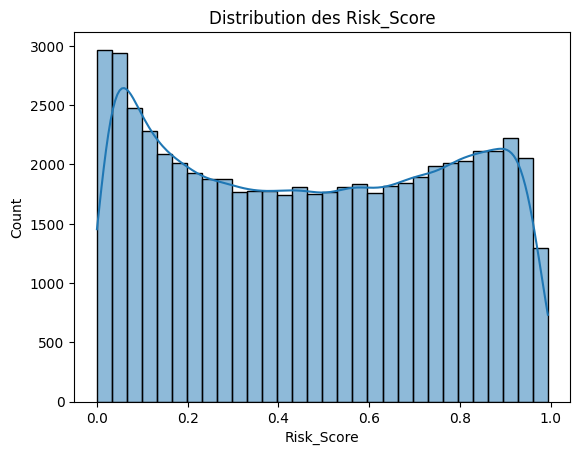

 Modèle entraîné, évalué, et prédictions exportées.


In [ ]:
# Notebook : Binaire → Multiclasse

# Imports
import pandas as pd
import numpy as np
import optuna
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import roc_auc_score, f1_score, make_scorer, classification_report, confusion_matrix

from xgboost import XGBClassifier

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
# Données
train = pd.read_csv("/home/nada/Project_odoo_17_IA-main/ML_Risque de depart/train.csv")
test = pd.read_csv("/home/nada/Project_odoo_17_IA-main/ML_Risque de depart/train.csv")

train['Attrition_Binary'] = train['Attrition'].map({'Stayed': 0, 'Left': 1})
X = train.drop(columns=['Employee ID', 'Attrition', 'Attrition_Binary'])
y = train['Attrition_Binary']

# Prétraitement
ordinal_map = {
    'Work-Life Balance': ['Poor', 'Fair', 'Good', 'Excellent'],
    'Job Satisfaction': ['Low', 'Medium', 'High', 'Very High'],
    'Performance Rating': ['Low', 'Below Average', 'Average', 'High'],
    'Employee Recognition': ['Low', 'Medium', 'High', 'Very High'],
    'Company Reputation': ['Poor', 'Fair', 'Good', 'Excellent']
}
ordinal_cols = list(ordinal_map.keys())
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()
onehot_cols = list(set(cat_cols) - set(ordinal_cols))

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("ord", OrdinalEncoder(categories=[ordinal_map[col] for col in ordinal_cols]), ordinal_cols),
    ("cat", OneHotEncoder(drop="first"), onehot_cols)
])

# Split validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#  Tuning Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "eval_metric": "logloss",
        "use_label_encoder": False
    }
    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", XGBClassifier(**params))
    ])
    return cross_val_score(pipeline, X_train, y_train, scoring=make_scorer(f1_score), cv=5).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
best_params = study.best_params

#  Entraînement final
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBClassifier(**best_params))
])
pipeline.fit(X_train, y_train)

# Évaluation validation
y_val_pred = pipeline.predict(X_val)
y_val_proba = pipeline.predict_proba(X_val)[:, 1]
print(classification_report(y_val, y_val_pred))

#Matrice de confusion
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion (validation)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

#  Génération Risk_Level sur tout le train
pipeline.fit(X, y)
probas = pipeline.predict_proba(X)[:, 1]
#[:, 1] sélectionne la probabilité de la classe "positive" ('Left': 1)
train["Risk_Score"] = probas.round(3)
#transforme les scores de risque en 3 catégories
train["Risk_Level"] = pd.cut(probas, bins=[0, 0.33, 0.66, 1.0], labels=['Low', 'Medium', 'High'])

sns.histplot(train["Risk_Score"], kde=True, bins=30)
plt.title("Distribution des Risk_Score")
plt.show()

# Sauvegarde
train.to_csv("/home/nada/Project_odoo_17_IA-main/ML_Risque de depart/train_with_risk.csv", index=False)
joblib.dump(pipeline, "/home/nada/Project_odoo_17_IA-main/ML_Risque de depart/train_with_risk.csv")

# Application sur test.csv
X_test = test.drop(columns=['Employee ID', 'Attrition'])
test_proba = pipeline.predict_proba(X_test)[:, 1]
test["Risk_Score"] = test_proba.round(3)
test["Risk_Level_Predicted"] = pd.cut(test_proba, bins=[0, 0.33, 0.66, 1.0], labels=['Low', 'Medium', 'High'])
test.to_csv("/home/nada/Project_odoo_17_IA-main/ML_Risque de depart/train_with_risk.csv", index=False)

print(" Modèle entraîné, évalué, et prédictions exportées.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
